In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "models":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [ ]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d

from src.data.database_manager import DatabaseManager
from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.log_config import configure_logging
from src.models.data_preparation import prepare_data
from src.models.main import RANDOM_SEED
from src.models.utils import get_device, load_model

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)


15:46:27 | INFO    | utils | Using device: mps
15:46:27 | INFO    | utils | Set seed to 42


In [3]:
device = get_device()
model, features = load_model(
    "results/experiment_eda_phasic_eda_tonic_heartrate_pupil_mean/model/PatchTST_20250429-141311.pt"
)


15:46:27 | INFO    | utils | Using device: mps
15:46:27 | INFO    | utils | Using device: mps
15:46:27 | INFO    | utils | Loaded PatchTST model with test accuracy 0.77%
15:46:27 | INFO    | utils | Input shape: (50, 4) | Features: ['eda_phasic', 'eda_tonic', 'heartrate', 'pupil_mean']


In [4]:
db = DatabaseManager()
with db:
    df = db.get_table("merged_and_labeled_data")

In [5]:
feature_list = [
    "eda_tonic",
    "eda_phasic",
    "pupil_mean",
    "heartrate",
]

sample_duration_ms = 5000

# Get particpant IDs from test set
test_ids = prepare_data(
    df,
    feature_list,
    sample_duration_ms,
    RANDOM_SEED,
    return_only_groups_for_test=True,
)
test_ids

array([ 7, 11, 17, 24, 30, 33, 36, 37, 48], dtype=uint8)

In [6]:
df.filter(participant_id=7)
df = df.filter(trial_id=320)

seed = df.get_column("stimulus_seed").unique().item()
seed

841

In [7]:
def create_samples_full_stimulus(df, features, sample_duration=5000, step_size=1000):
    """
    Create samples from dataframe with specified duration and step size.

    Args:
        df: Polars DataFrame with a 'normalized_timestamp' column
        sample_duration: Duration of each sample in milliseconds (default: 5000)
        step_size: Spacing between sample starts in milliseconds (default: 1000)

    Returns:
        List of DataFrames, each representing a sample
    """
    # Get min and max timestamps
    min_time = df["normalized_timestamp"].min()
    max_time = df["normalized_timestamp"].max()

    # Generate sample start times
    sample_starts = np.arange(min_time, max_time - sample_duration + 1, step_size)

    # Create samples
    samples = []
    for start in sample_starts:
        end = start + sample_duration
        sample = df.filter(
            (df["normalized_timestamp"] >= start) & (df["normalized_timestamp"] < end)
        ).select(features)

        # Only include non-empty samples
        if sample.height > 0:
            samples.append(sample)

    print(
        f"Created {len(samples)} samples of {sample_duration}ms duration with {step_size}ms spacing"
    )
    return samples


# Create samples from your DataFrame (df)
samples = create_samples_full_stimulus(df, features)

# Example of working with the samples
print(f"First sample has {samples[0].height} rows")
print(f"Last sample has {samples[-1].height} rows")


Created 176 samples of 5000ms duration with 1000ms spacing
First sample has 50 rows
Last sample has 50 rows


In [ ]:
predictions = []
for sample in samples:
    tensor = (
        torch.tensor(sample.to_numpy(), dtype=torch.float32).unsqueeze(0).to(device)
    )
    logits = model(tensor)
    probabilities = torch.softmax(logits, dim=1)
    predictions.append(probabilities.argmax(dim=1).item())


841


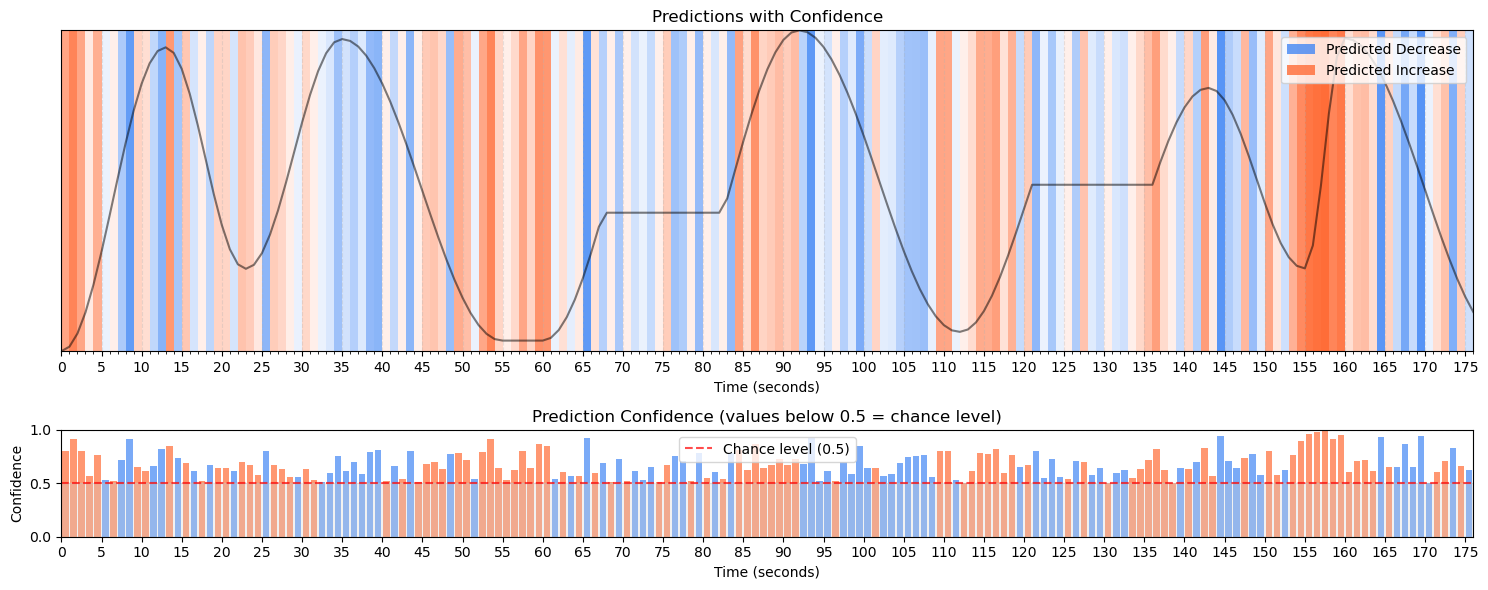

In [30]:
def visualize_predictions_as_blocks(predictions, confidences, sample_duration=1):
    """
    Visualize predictions as colored blocks on a timeline with color intensity indicating confidence.

    Args:
        predictions: List or array of binary predictions (0 or 1)
        confidences: List or array of confidence values (between 0 and 1)
        sample_duration: Duration of each sample in seconds
    """
    # Ensure predictions and confidences have the same length
    assert len(predictions) == len(confidences), (
        "Predictions and confidences must have same length"
    )

    # Create figure and axis
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(15, 6), gridspec_kw={"height_ratios": [3, 1]}
    )

    # Calculate total time duration
    total_duration = len(predictions) * sample_duration

    # Set up the main prediction plot
    ax1.set_xlim(0, total_duration)
    ax1.set_ylim(0, 1)
    ax1.set_yticks([])  # Remove y-axis ticks
    ax1.set_xlabel("Time (seconds)")
    ax1.set_title("Predictions with Confidence")

    # Define better colors
    class_colors = {
        0: "#4287f5",  # Vibrant blue for decrease
        1: "#ff6b35",  # Vibrant orange for increase
    }

    # Create colored blocks for each prediction
    for i, (pred, conf) in enumerate(zip(predictions, confidences)):
        start_time = i * sample_duration

        # Normalize confidence: emphasize high confidence areas
        # Scaled to make visualization more impactful (0.5 → transparent, 1.0 → full color)
        norm_conf = (conf - 0.5) * 2  # Scale from [0.5, 1.0] to [0, 1.0]
        norm_conf = max(0.1, norm_conf)  # Ensure some minimal visibility

        # Add colored rectangle with confidence-based opacity
        rect = plt.Rectangle(
            (start_time, 0),
            sample_duration,
            1,
            facecolor=class_colors[pred],
            alpha=norm_conf,
        )
        ax1.add_patch(rect)

    # Add a legend
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor=class_colors[0], alpha=0.8, label="Predicted Decrease"),
        Patch(facecolor=class_colors[1], alpha=0.8, label="Predicted Increase"),
    ]
    ax1.legend(handles=legend_elements, loc="upper right")

    # Add grid for better readability
    ax1.grid(True, axis="x", linestyle="--", alpha=0.3)

    # Add time markers
    ax1.set_xticks(np.arange(0, total_duration + 1, 5))  # Major ticks every 5 seconds
    ax1.set_xticks(
        np.arange(0, total_duration + 1, 1), minor=True
    )  # Minor ticks every 1 second

    stim = StimulusGenerator(seed=seed)
    print(seed)
    stimulus = stim.y[::10]
    # min max scaling
    stimulus = (stimulus - stimulus.min()) / (stimulus.max() - stimulus.min())
    ax1.plot(stimulus, "k", alpha=0.5)

    # Add confidence plot below highlighting chance level
    time_points = np.arange(len(confidences)) * sample_duration + (sample_duration / 2)

    # Color bars according to prediction class
    bar_colors = [class_colors[pred] for pred in predictions]

    # Plot bars with class-based colors
    bars = ax2.bar(
        time_points,
        confidences,
        width=sample_duration * 0.8,
        color=bar_colors,
        alpha=0.7,
    )

    # Add chance level line
    ax2.axhline(
        y=0.5, color="red", linestyle="--", alpha=0.7, label="Chance level (0.5)"
    )

    # Fill area below chance level with light gray
    ax2.fill_between(ax2.get_xlim(), 0, 0.5, color="lightgray", alpha=0.3)

    ax2.set_xlim(0, total_duration)
    ax2.set_ylim(0, 1)
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Confidence")
    ax2.set_title("Prediction Confidence (values below 0.5 = chance level)")
    ax2.grid(True, axis="y", linestyle="--", alpha=0.3)
    ax2.set_xticks(np.arange(0, total_duration + 1, 5))
    ax2.legend()

    plt.tight_layout()
    return fig


# Extract both predictions and confidences
predictions = []
confidences = []
for sample in samples:
    tensor = (
        torch.tensor(sample.to_numpy(), dtype=torch.float32).unsqueeze(0).to(device)
    )
    logits = model(tensor)
    probabilities = torch.softmax(logits, dim=1)
    pred_class = probabilities.argmax(dim=1).item()
    pred_confidence = probabilities[0, pred_class].item()
    predictions.append(pred_class)
    confidences.append(pred_confidence)

visualize_predictions_as_blocks(predictions, confidences);

In [ ]:
# Calculate confidences and predictions from samples
predictions = []
confidences = []
for sample in samples:
    tensor = (
        torch.tensor(sample.to_numpy(), dtype=torch.float32).unsqueeze(0).to(device)
    )
    logits = model(tensor)
    probabilities = torch.softmax(logits, dim=1)
    pred_class = probabilities.argmax(dim=1).item()
    pred_confidence = probabilities[0, pred_class].item()
    predictions.append(pred_class)
    confidences.append(pred_confidence)

# Define the participants and stimulus seed
test_participant_ids = [7, 11, 17, 24, 30, 33, 36, 37, 48]
stimulus_seed = 841  # Use the appropriate seed value


def analyze_test_dataset(participant_ids, stimulus_seed):
    """
    Analyze the entire test dataset with the specified stimulus seed.
    Args:
        participant_ids: List of participant IDs to analyze
        stimulus_seed: Stimulus seed to filter for
    Returns:
        all_predictions: Dictionary mapping participant_id to their predictions
        all_confidences: Dictionary mapping participant_id to their confidences
        participant_trials: Dictionary mapping participant_id to number of trials
    """
    all_predictions = {}
    all_confidences = {}
    participant_trials = {}

    # Process each participant
    for participant_id in participant_ids:
        print(f"Processing participant {participant_id}...")
        # Get data for this participant and stimulus seed
        with db:
            participant_df = db.get_table("merged_and_labeled_data").filter(
                (pl.col("participant_id") == participant_id)
                & (pl.col("stimulus_seed") == stimulus_seed)
            )

        if participant_df.is_empty():
            print(
                f"No data found for participant {participant_id} with stimulus seed {stimulus_seed}"
            )
            continue

        # Get all trials for this participant with this stimulus
        trial_ids = participant_df.get_column("trial_id").unique()
        print(f" Found {len(trial_ids)} trials")
        participant_predictions = []
        participant_confidences = []

        # Process each trial
        for trial_id in trial_ids:
            trial_df = participant_df.filter(pl.col("trial_id") == trial_id)
            # Create samples for this trial
            samples = create_samples_full_stimulus(trial_df, features)

            if not samples:
                print(f" No valid samples for trial {trial_id}")
                continue

            # Get predictions and confidences for this trial
            trial_predictions = []
            trial_confidences = []
            for sample in samples:
                tensor = (
                    torch.tensor(sample.to_numpy(), dtype=torch.float32)
                    .unsqueeze(0)
                    .to(device)
                )
                logits = model(tensor)
                probabilities = torch.softmax(logits, dim=1)
                pred_class = probabilities.argmax(dim=1).item()
                pred_confidence = probabilities[0, pred_class].item()
                trial_predictions.append(pred_class)
                trial_confidences.append(pred_confidence)

            participant_predictions.append(trial_predictions)
            participant_confidences.append(trial_confidences)

        if participant_predictions:
            all_predictions[participant_id] = participant_predictions
            all_confidences[participant_id] = participant_confidences
            participant_trials[participant_id] = len(participant_predictions)

    return all_predictions, all_confidences, participant_trials


# Analyze the entire test dataset
print("Analyzing the entire test dataset...")
all_predictions, all_confidences, participant_trials = analyze_test_dataset(
    test_participant_ids, stimulus_seed
)


# Resample to align time series
def align_time_series(predictions_dict, confidences_dict, target_length=100):
    """
    Align all prediction and confidence time series to the same length.
    Args:
        predictions_dict: Dictionary of participant predictions
        confidences_dict: Dictionary of participant confidences
        target_length: Length to resample all series to
    Returns:
        aligned_predictions: Dictionary of resampled predictions
        aligned_confidences: Dictionary of resampled confidences
    """

    aligned_predictions = {}
    aligned_confidences = {}

    for participant_id in predictions_dict.keys():
        aligned_predictions[participant_id] = []
        aligned_confidences[participant_id] = []

        for i in range(len(predictions_dict[participant_id])):
            predictions = predictions_dict[participant_id][i]
            confidences = confidences_dict[participant_id][i]

            # Skip empty trials
            if not predictions:
                continue

            # Create indices for original data
            old_indices = np.linspace(0, 1, len(predictions))

            # Create function for interpolation of confidences
            f_conf = interp1d(old_indices, confidences, kind="linear")

            # Create new indices for target length
            new_indices = np.linspace(0, 1, target_length)

            # Resample confidences
            resampled_confidences = f_conf(new_indices)

            # For predictions (class labels), we need to use nearest neighbor interpolation
            # since we can't interpolate between class labels
            f_pred = interp1d(old_indices, predictions, kind="nearest")
            resampled_predictions = f_pred(new_indices)

            aligned_predictions[participant_id].append(resampled_predictions)
            aligned_confidences[participant_id].append(resampled_confidences)

    return aligned_predictions, aligned_confidences


# Align all time series to the same length
target_length = 180  # Adjust this based on your needs
aligned_predictions, aligned_confidences = align_time_series(
    all_predictions, all_confidences, target_length
)


Analyzing the entire test dataset...
Processing participant 7...
 Found 1 trials
Created 176 samples of 5000ms duration with 1000ms spacing
Processing participant 11...
 Found 1 trials
Created 176 samples of 5000ms duration with 1000ms spacing
Processing participant 17...
 Found 1 trials
Created 176 samples of 5000ms duration with 1000ms spacing
Processing participant 24...
 Found 1 trials
Created 176 samples of 5000ms duration with 1000ms spacing
Processing participant 30...
 Found 1 trials
Created 176 samples of 5000ms duration with 1000ms spacing
Processing participant 33...
 Found 1 trials
Created 176 samples of 5000ms duration with 1000ms spacing
Processing participant 36...
 Found 1 trials
Created 176 samples of 5000ms duration with 1000ms spacing
Processing participant 37...
 Found 1 trials
Created 176 samples of 5000ms duration with 1000ms spacing
Processing participant 48...
 Found 1 trials
Created 176 samples of 5000ms duration with 1000ms spacing


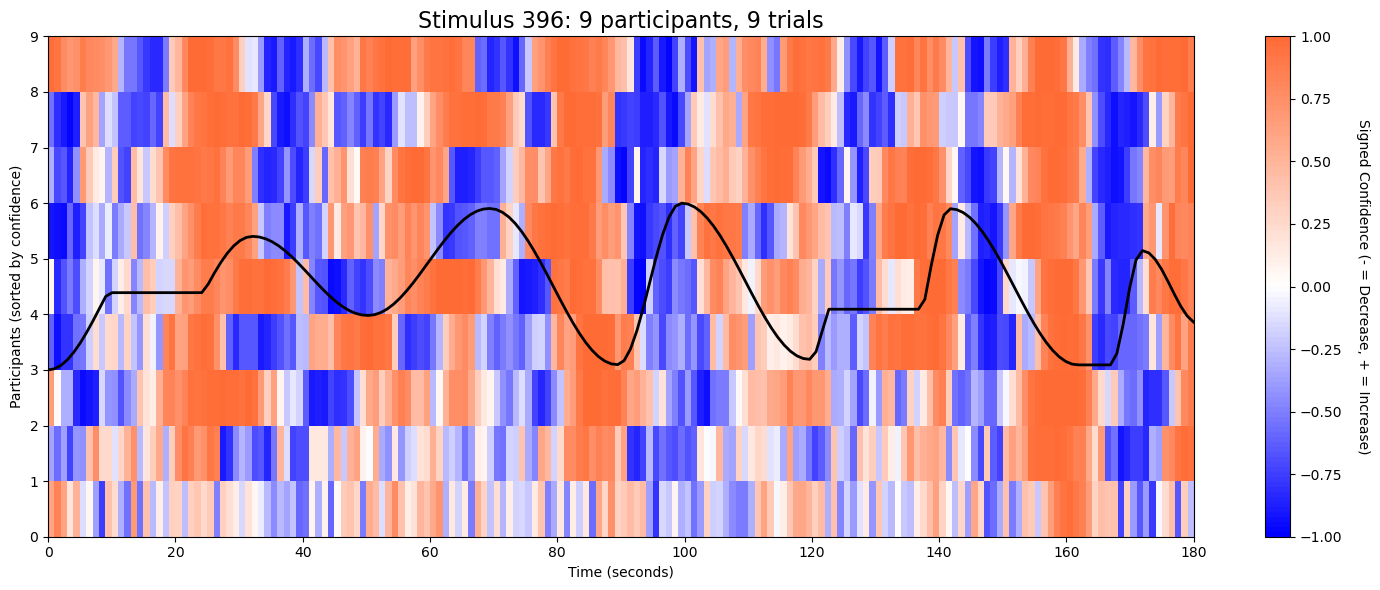

In [28]:
def create_aggregate_visualization(
    aligned_predictions, aligned_confidences, stimulus_seed
):
    """
    Create a heatmap visualization of model predictions across all trials.
    Args:
        aligned_predictions: Dictionary of aligned predictions for each participant
        aligned_confidences: Dictionary of aligned confidences for each participant
        stimulus_seed: Seed used for the stimulus generation
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 6))

    # Combine all trials into a single matrix with signed confidences
    all_confidences_matrix = []

    for participant_id in aligned_confidences:
        for i, trial_confidences in enumerate(aligned_confidences[participant_id]):
            trial_predictions = aligned_predictions[participant_id][i]

            # Transform classifier confidences to centered, scaled values [-1, 1]
            signed_confidences = [
                -(conf - 0.5) * 2 if pred == 0 else (conf - 0.5) * 2
                for conf, pred in zip(trial_confidences, trial_predictions)
            ]
            all_confidences_matrix.append(signed_confidences)

    # Convert to numpy array and sort by average confidence
    confidence_array = np.array(all_confidences_matrix)
    avg_confidence = np.mean(np.abs(confidence_array), axis=1)
    sorted_confidence_array = confidence_array[np.argsort(-avg_confidence)]

    # Create custom colormap: blue for negative, white for 0, orange for positive
    colors = [(0, 0, 1), (1, 1, 1), (1, 0.42, 0.21)]  # Blue, White, Orange
    cmap = LinearSegmentedColormap.from_list("BlueWhiteOrange", colors, N=100)

    # Create time axis
    time_points = np.linspace(0, 180, confidence_array.shape[1])

    # Get and process stimulus signal
    stim = StimulusGenerator(seed=stimulus_seed)
    stimulus = stim.y[::10]  # Downsample to match typical alignment length

    # Resample stimulus to match confidence array length
    f = interp1d(np.linspace(0, 1, len(stimulus)), stimulus)
    stimulus_resampled = f(np.linspace(0, 1, confidence_array.shape[1]))

    # Normalize stimulus to [-1, 1]
    stimulus_line = (
        2
        * (
            (stimulus_resampled - stimulus_resampled.min())
            / (stimulus_resampled.max() - stimulus_resampled.min())
        )
        - 1
    )

    # Plot heatmap
    im = ax.imshow(
        sorted_confidence_array,
        aspect="auto",
        cmap=cmap,
        vmin=-1,
        vmax=1,
        extent=(0, 180, 0, len(sorted_confidence_array)),
    )

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(
        "Signed Confidence (- = Decrease, + = Increase)", rotation=270, labelpad=20
    )

    # Add stimulus line overlay
    scaled_stimulus_y = len(sorted_confidence_array) / 2
    ax.plot(
        time_points,
        stimulus_line * (scaled_stimulus_y / 3) + scaled_stimulus_y,
        "k-",
        linewidth=2,
        label="Stimulus",
    )

    # Add labels and statistics
    num_participants = len(aligned_confidences)
    total_trials = len(sorted_confidence_array)
    ax.set_title(
        f"Stimulus {stimulus_seed}: {num_participants} participants, {total_trials} trials",
        fontsize=16,
    )
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Participants (sorted by confidence)")

    plt.tight_layout()
    return fig


# Create the visualization
aggregate_fig = create_aggregate_visualization(
    aligned_predictions, aligned_confidences, stimulus_seed=396
)
plt.show()